# Programming for Finance Assignment
## Spring 2017
### Christopher Rosholm - 24896389

## Preamp

In [1]:
%matplotlib notebook
#Remove if not in Jupyter notebook
#Preamp
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-whitegrid')
#print(plt.style.available)
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
import pandas_datareader.data as web
import datetime as dt
import statsmodels.tools
plt.clf
plt.cla
plt.close('all')

## Data import - main dataframe

In [2]:
path = str('C:\data\Assignment\data.xlsx') #This is the path from where I retrieve my data

# Had trouble obtaining data for Nikkei225 from Reuters, so I'll use 
# Yahoo Finance API
start = dt.datetime(2010,1,1) # Defining a start date for my web request
end = dt.datetime(2017,3,1) # Defining a end date for my web request

nikkei = web.DataReader('^N225', 'yahoo', start, end) # Dataframe with values for the Nikkei225 index
df = pd.read_excel(path,parse_cols="F:T",index_col=0, header=2, sheetname="Sheet2") # Main dataframe for all other instruments

# To ensure that I have data for all instruments, I slice my dataframe to align the dataframe
df = df.ix[0:1294]
df = df.merge(nikkei, left_index = True, right_index= True, how='left' )
df.drop(df.columns[[2,14,15,16,18,19]], axis=1, inplace=True)
df.rename(columns={'Close': '.N225'}, inplace=True) 


df=df.fillna(method='ffill') # As there are some missing values due to holidays etc. I fill those values from last valid observation

# Importing key dates and assigning them as a pandas Series
dates = pd.read_excel(path, parse_cols="F", skiprows = 2, header=0, sheetname="Sheet2")
dates = pd.Series(df.index)

After import all my data, I end up with a dataframe looking like this:

In [3]:
df.head()

,.FTSE,.HSCI,.FTMIB,.MCX,.FCHI,.SPX,.GDAXI,GBPEUR,GBPUSD,GB 10Y GILT,GB 7Y GILT,GB 2Y GILT,GB 3M T-BILL,.N225
Date,,,,,,,,,,,,,,
2017-03-01,"7,382.90","3,253.68","19,364.39","2,059.87","4,960.83","2,395.96","12,067.19",1.17,1.23,1.19,0.82,0.10,0.21,"19,393.54"
2017-02-28,"7,263.44","3,243.05","18,913.28","2,035.77","4,858.58","2,363.64","11,834.41",1.17,1.24,1.14,0.78,0.08,0.21,"19,118.99"
2017-02-27,"7,253.00","3,262.23","18,914.30","2,056.46","4,845.18","2,369.75","11,822.67",1.17,1.24,1.15,0.80,0.09,0.21,"19,107.47"
2017-02-24,"7,243.70","3,273.22","18,596.66","2,093.09","4,845.24","2,367.34","11,804.03",1.18,1.25,1.07,0.64,0.07,0.21,"19,283.54"
2017-02-23,"7,271.37","3,299.29","18,819.49","2,093.09","4,891.29","2,363.81","11,947.83",1.19,1.26,1.15,0.70,0.07,0.21,"19,371.46"


## Constructed functions

In [4]:
# Calculating log returns:
def calculate_logreturns(dataframe):
    df_return = np.log(dataframe/dataframe.shift(-1))
    return df_return

# Function for importing key dates:    
keypath = str('C:/Users/Christopher/Dropbox/2. ICMA Centre/2. Module/ICM142 - Programming for Finance/Assignment/keydates.xlsx')
def import_keydates(pathkey):
    "This is a function to retrieve key dates from an Excel sheet and append them in a list"
    temp1 = pd.read_excel(pathkey,names=['Dates'], parse_cols="A")
    temp2 = temp1['Dates']
    key_dates = []
    for j in range (0,len(temp2)):
        key_dates.append(pd.to_datetime(temp2.loc[j]))
    return key_dates

# Iterating through key dates to assign dummy variables:
def iteration(input_list, key_list, assigned_variable):
    """This function allows me to easily construct a list of dummy variables that depends on already pre-defined key dates"""
    dummy = []
    for i in range(0,len(input_list)):
        if input_list.loc[i] in key_list:
            dummy.append(int(assigned_variable))
        else:
            dummy.append(0)
    return dummy

# Function for localizing index values of my key dates in the dataframe
def index_keys(inputlist):
    """
    This function is created to find index values for the key dates
    this is helpful when I want to find cumulative returns
    """
    indexer = []
    for item in inputlist:
        indexer.append(df_return.index.get_loc(item))
    indexer.sort()
    return indexer

# Cumulative list creator
def cumulative_list(index_list, start, end):
    """
    This function creates a list with index keys obtained from the index_keys function for T-t and T+t,
    """
    test = []
    for i in range (0,len(index_list)):
        test2 = []
        for j in range (index_list[i]+int(start),index_list[i]+int(end)+1):
            test2.append(j)
        test.append(test2)
    return test


def index_plot(inlist):
    """This function is used to create an indexed series, so it is possible
    to plot multiple series in a figure"""
    temp = inlist.sort_index()
    ydata = []
    xdata = inlist.sort_index().index
    for i in range (0,len(inlist.index)):
        ydata.append(temp[i]/temp[0])
    
    return ydata, xdata

def Q5_appender(event):
    """
    This function creates appends either positive or negative depending on whether the market return was
    positive or negative on a key event date
    """
    iterationlist = df_return.loc[event]
    appending = []
    for item in iterationlist.index:
        if item == 'Dummy Variables':
            del iterationlist['Dummy Variables']
            break 
    for subitem in iterationlist:
        if subitem > 0:
            appending.append('Positive')
        else:
            appending.append('Negative')
    return appending

# Function for calculating average, std. dev. and median, and then transposing the vectors:
def avgstdmedian(df):
    std = df.std(axis=0,ddof=1)
    average = df.mean(axis=0)
    median = df.median(axis=0)
    std = pd.DataFrame(data=std).transpose()
    average = pd.DataFrame(data=average).transpose()
    median = pd.DataFrame(data=median).transpose()
    return std, average, median

df_return = calculate_logreturns(df) # Creating a dataframe consisting of my log returns for all instruments
key_dates = import_keydates(keypath) # Importing all identified key dates from my excel sheet
dummy_variables = iteration(dates,key_dates,1) # Constructing a indicator function using dummy variables with the value of 1

df_return['Dummy Variables'] = dummy_variables
Index_keys = index_keys(key_dates)
List_for_cumulative_returns = cumulative_list(Index_keys,start=-5,end=5)

Calculating mean, standard deviation and median for the dataframe, excluding the dummy variable

In [5]:
[std0, average0, median0] = avgstdmedian(df_return)

For instance, this yields the following table for standard deviations:

In [6]:
std0*100

,.FTSE,.HSCI,.FTMIB,.MCX,.FCHI,.SPX,.GDAXI,GBPEUR,GBPUSD,GB 10Y GILT,GB 7Y GILT,GB 2Y GILT,GB 3M T-BILL,.N225,Dummy Variables
0,0.89,1.06,1.60,1.18,1.20,0.79,1.18,0.53,0.57,3.11,4.19,14.15,3.03,1.45,7.34


## Timeline

<IPython.core.display.Javascript object>


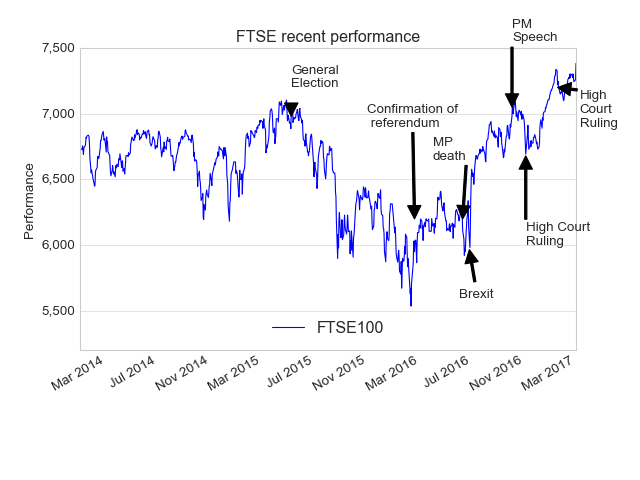

In [7]:
fig = plt.figure()

ax1 = plt.subplot2grid((1,1),(0,0))

Ydata = df['.FTSE'].sort_index()
#Ydata2 = index_plotting(df['GBPEUR'])
Xdata = df['.FTSE'].index.sort_values()

ax1.plot(Xdata, Ydata, '-', label='FTSE100')
#ax1.plot_date(Xdata, Ydata2, '-', label='GBPEUR')

fig.autofmt_xdate()
#plt.xlabel('Dates')
plt.ylabel('Performance')
plt.title('FTSE recent performance')
#plt.subplots_adjust(left = 0.05, bottom = 0.1, right = .65, top = 0.95, wspace = 0.9, hspace = 0)
box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
    box.width, box.height * 0.9])
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0),
    fancybox=True, shadow=True, ncol=8)
ax1.xaxis.grid(False)
ax1.yaxis.grid(alpha = 1)

plt.xlim('2014-01-01','2017-03-01')
plt.ylim(5200,7500)

plt.annotate('General\nElection', xy=('2015-05-08',6900), xytext=('2015-05-08',7200),
            arrowprops=dict(facecolor='black', shrink=0.29, width=2),
            )

plt.annotate('Confirmation of\n referendum', xy=('2016-02-19',6200), xytext=('2015-11-01',6900),
            arrowprops=dict(facecolor='black', shrink=0.0, width=2),
            )

plt.annotate('MP\ndeath', xy=('2016-06-10',6200), xytext=('2016-04-01',6650),
            arrowprops=dict(facecolor='black', shrink=1, width=2),
            )
plt.annotate('Brexit', xy=('2016-06-24',6000), xytext=('2016-06-01',5600),
            arrowprops=dict(facecolor='black', shrink=0.1, width=2),
            )
plt.annotate('PM\nSpeech', xy=('2016-10-03',7050), xytext=('2016-10-03',7550),
            arrowprops=dict(facecolor='black', shrink=1, width=2),
            )

plt.annotate('High Court\nRuling', xy=('2016-11-04',6680), xytext=('2016-11-04',6000),
            arrowprops=dict(facecolor='black', shrink=1, width=2),
            )
plt.annotate('High\nCourt\nRuling', xy=('2017-01-17',7200), xytext=('2017-03-10',6900),
            arrowprops=dict(facecolor='black', shrink=1, width=2),
            )
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y,_:'{:,.0f}'.format(y)))

plt.show()
savepath = 'C:/Users/Christopher/Dropbox/2. ICMA Centre/PROTEXT test/Q1/Timeline.png'
plt.savefig(savepath,transparent = False, dpi = 200, bbox_inches="tight")

## Calculations for Question 2 - 3

In this section, I only consider the British financial markets. I create another dataframe in order to 
derive estimates for median, average and standard deviation for the different instruments

I start of by creating a new dataframe where I only include instruments for UK:

In [8]:
FTSE_key_events_df = df_return[df_return['Dummy Variables']==1]
FTSE_key_events_df = FTSE_key_events_df[['.FTSE', 'GB 10Y GILT', 'GB 7Y GILT', 'GB 2Y GILT', 'GB 3M T-BILL','GBPEUR', 'GBPUSD']]
FTSE_key_events_df.sort_index(ascending=True, inplace = True)

FTSE_key_events_df.head(n=10)

,.FTSE,GB 10Y GILT,GB 7Y GILT,GB 2Y GILT,GB 3M T-BILL,GBPEUR,GBPUSD
Date,,,,,,,
2015-05-08,0.02,-0.03,-0.03,-0.06,-0.00,0.02,0.01
2016-02-19,-0.00,-0.02,-0.02,-0.02,-0.04,-0.00,0.01
2016-06-16,-0.00,-0.00,0.00,0.03,-0.06,0.00,-0.00
2016-06-24,-0.03,-0.23,-0.31,-0.69,-0.14,-0.06,-0.08
2016-10-03,0.01,-0.04,-0.06,-0.30,0.10,-0.01,-0.01
2016-11-04,-0.01,-0.05,-0.08,-0.16,-0.03,0.00,0.00
2017-01-17,-0.01,-0.01,-0.01,0.11,-0.02,0.02,0.03


Then, I calculate the standard deviation, average and median for the new dataframe. To include the calculated values in the already existing dataframe, I need to add the vectors consisting of the values as a row and rename the index. This is achieved utilizing my previously defined funtion:

In [9]:
[std, average, median] = avgstdmedian(FTSE_key_events_df)


After appending the values to the dataframe, I rename their index as follows:

In [10]:
FTSE_key_events_df = FTSE_key_events_df.append(std)
FTSE_key_events_df = FTSE_key_events_df.rename(index={0: 'Standard dev'}) # After appending the row, the index is automatically
                                                                            # assumed to be '0', which I can use to rename the value
FTSE_key_events_df = FTSE_key_events_df.append(average)
FTSE_key_events_df = FTSE_key_events_df.rename(index={0: 'Average return'})
FTSE_key_events_df = FTSE_key_events_df.append(median)
FTSE_key_events_df = FTSE_key_events_df.rename(index={0: 'Median'})

This yields a dataframe with returns for all identified key dates, along with the calculated standard deviation, average and median for these dates:

In [11]:
pivoted = np.round(FTSE_key_events_df*100, decimals=2) # Rounds down to two decimals, and multiplies with 100 for presentation purposes only
pivoted

#pivoted.to_excel('FTSE_Key_dates.xlsx') # This is done to export the dataframe to Excel and subsequently LaTeX

,.FTSE,GB 10Y GILT,GB 7Y GILT,GB 2Y GILT,GB 3M T-BILL,GBPEUR,GBPUSD
2015-05-08 00:00:00,2.29,-2.90,-2.90,-5.57,-0.21,1.82,1.37
2016-02-19 00:00:00,-0.36,-1.69,-2.28,-2.13,-4.06,-0.05,0.51
2016-06-16 00:00:00,-0.27,-0.18,0.00,3.39,-6.18,0.29,-0.01
2016-06-24 00:00:00,-3.20,-23.38,-30.73,-69.12,-14.12,-6.19,-8.41
2016-10-03 00:00:00,1.21,-3.78,-6.00,-30.11,9.66,-0.79,-1.04
2016-11-04 00:00:00,-1.44,-5.48,-8.02,-15.79,-2.56,0.13,0.46
2017-01-17 00:00:00,-1.47,-1.30,-1.37,10.82,-2.20,1.93,3.03
Standard dev,1.82,8.06,10.68,27.13,7.11,2.74,3.67
Average return,-0.46,-5.53,-7.33,-15.50,-2.81,-0.41,-0.58
Median,-0.36,-2.90,-2.90,-5.57,-2.56,0.13,0.46


The next step is to calculate a correlation matrix. This is also done using pandas own functions:

In [12]:
correlation_table = df_return[['.FTSE', 'GB 10Y GILT', 'GB 7Y GILT', 'GB 2Y GILT', 'GB 3M T-BILL','GBPEUR', 'GBPUSD', 'Dummy Variables']]
correlation_table = correlation_table.corr()
correlation_table = np.round(correlation_table, decimals = 3)
correlation_table
#correlation_table.to_excel('CorrelationQ1.xlsx')

,.FTSE,GB 10Y GILT,GB 7Y GILT,GB 2Y GILT,GB 3M T-BILL,GBPEUR,GBPUSD,Dummy Variables
.FTSE,1.00,0.27,0.26,0.14,0.00,0.08,0.02,-0.04
GB 10Y GILT,0.27,1.00,0.94,0.53,0.12,0.21,0.22,-0.13
GB 7Y GILT,0.26,0.94,1.00,0.62,0.12,0.21,0.22,-0.13
GB 2Y GILT,0.14,0.53,0.62,1.00,0.04,0.14,0.15,-0.08
GB 3M T-BILL,0.00,0.12,0.12,0.04,1.00,0.07,0.09,-0.07
GBPEUR,0.08,0.21,0.21,0.14,0.07,1.00,0.53,-0.06
GBPUSD,0.02,0.22,0.22,0.15,0.09,0.53,1.00,-0.07
Dummy Variables,-0.04,-0.13,-0.13,-0.08,-0.07,-0.06,-0.07,1.00


This process is now repeated, only now I'm doing it for the international stock markets:

In [13]:
Q2 = df_return[df_return['Dummy Variables']==1] 
Q2 = Q2[['.FTSE', '.HSCI', '.FTMIB', '.MCX', '.FCHI', '.SPX', '.GDAXI', '.N225']]
Q2 = Q2.sort_index()
[std, average, median] = avgstdmedian(Q2)

Q2 = Q2.append(std)
Q2 = Q2.rename(index={0: 'Standard dev'})
Q2 = Q2.append(average)
Q2 = Q2.rename(index={0: 'Average return'})
Q2 = Q2.append(median)
Q2 = Q2.rename(index={0: 'Median'})

Q2 = np.round((Q2*100),decimals=2)
Q2
# Q2.to_excel('InternationalMarketReactions.xlsx')

,.FTSE,.HSCI,.FTMIB,.MCX,.FCHI,.SPX,.GDAXI,.N225
2015-05-08 00:00:00,2.29,1.70,2.04,1.27,2.45,1.34,2.61,0.45
2016-02-19 00:00:00,-0.36,-0.25,-1.19,-0.77,-0.40,-0.00,-0.80,-1.43
2016-06-16 00:00:00,-0.27,-1.88,-0.99,-1.06,-0.45,0.31,-0.59,-3.10
2016-06-24 00:00:00,-3.20,-2.75,-13.33,-1.83,-8.38,-3.66,-7.07,-8.25
2016-10-03 00:00:00,1.21,1.21,-0.78,0.44,0.12,-0.33,1.03,0.90
2016-11-04 00:00:00,-1.44,-0.16,-0.62,-0.51,-0.78,-0.17,-0.65,0.00
2017-01-17 00:00:00,-1.47,0.70,0.25,-0.47,-0.46,0.00,-0.13,-1.49
Standard dev,1.82,1.62,5.08,1.01,3.38,1.55,3.02,3.14
Average return,-0.46,-0.20,-2.09,-0.42,-1.13,-0.36,-0.80,-1.84
Median,-0.36,-0.16,-0.78,-0.51,-0.45,-0.00,-0.59,-1.43


In [14]:
Q2_corr = df_return[['.FTSE', '.HSCI', '.FTMIB', '.MCX', '.FCHI', '.SPX', '.GDAXI', '.N225', 'Dummy Variables']]
Q2_corr = Q2_corr.corr()
Q2_corr = np.round(Q2_corr, decimals = 3)
Q2_corr
#Q2_corr.to_excel('CorrelationQ2.xlsx')

,.FTSE,.HSCI,.FTMIB,.MCX,.FCHI,.SPX,.GDAXI,.N225,Dummy Variables
.FTSE,1.00,0.41,0.71,0.44,0.83,0.57,0.79,0.27,-0.04
.HSCI,0.41,1.00,0.30,0.33,0.38,0.24,0.37,0.42,-0.01
.FTMIB,0.71,0.30,1.00,0.40,0.86,0.54,0.81,0.24,-0.10
.MCX,0.44,0.33,0.40,1.00,0.44,0.32,0.46,0.20,-0.03
.FCHI,0.83,0.38,0.86,0.44,1.00,0.60,0.92,0.27,-0.07
.SPX,0.57,0.24,0.54,0.32,0.60,1.00,0.57,0.17,-0.04
.GDAXI,0.79,0.37,0.81,0.46,0.92,0.57,1.00,0.27,-0.05
.N225,0.27,0.42,0.24,0.20,0.27,0.17,0.27,1.00,-0.10
Dummy Variables,-0.04,-0.01,-0.10,-0.03,-0.07,-0.04,-0.05,-0.10,1.00


## Regressions for Question 2 - 3

### Regressions for UK markets only

To run all the different regressions, I have chosen to wrap all regression results in a single dictionary as follows:

In [15]:
regression1 = {} # Preparing a dictionary for use
Ydata = FTSE_key_events_df.columns # Retrieves a list of the different instruments for use
xdata = df_return['Dummy Variables'][:-1] # Excluding the last observation to align the indicator vector with the dataframe
for item in Ydata:
    results = 0
    ydata = df_return[item][:-1]
    results = sm.OLS(ydata, statsmodels.tools.add_constant(xdata)).fit()
    regression1[item] = results

# All regression results are now stored in the dictionary and can easily be accessed:
regression1['GB 10Y GILT'].summary()

# The regression results are then transferred to Excel using Rodeo's copy function

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GB 10Y GILT   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     22.23
Date:                Wed, 19 Apr 2017   Prob (F-statistic):           2.68e-06
Time:                        15:56:41   Log-Likelihood:                 2666.0
No. Observations:                1293   AIC:                            -5328.
Df Residuals:                    1291   BIC:                            -5318.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const              -0.0002      0.001     -0.290      0.772        -0.002     0.001
Dummy Variables    -0.0550      0.012     -4.715      0.000        -0.078    -0.032
==============================================================================
Omnibus:                      146.092   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1247.633
Skew:                          -0.068   Prob(JB):                    1.20e-271
Kurtosis:                       7.810   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regressions for international markets

The same procedure is employed for international markets:

In [16]:
regression2 = {} # Preparing a dictionary for use
Ydata = Q2.columns # Retrieves a list of the different instruments for use
xdata = df_return['Dummy Variables'][:-1] # Excluding the last observation to align the indicator vector with the dataframe
for item in Ydata:
    results = 0
    ydata = df_return[item][:-1]
    results = sm.OLS(ydata, statsmodels.tools.add_constant(xdata)).fit()
    regression2[item] = results

# All regression results are now stored in the dictionary and can easily be accessed:
regression2['.HSCI'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  .HSCI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2832
Date:                Wed, 19 Apr 2017   Prob (F-statistic):              0.595
Time:                        15:56:41   Log-Likelihood:                 4048.7
No. Observations:                1293   AIC:                            -8093.
Df Residuals:                    1291   BIC:                            -8083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const             9.38e-05      0.000      0.318      0.750        -0.000     0.001
Dummy Variables    -0.0021      0.004     -0.532      0.595        -0.010     0.006
==============================================================================
Omnibus:                      118.014   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              581.167
Skew:                          -0.262   Prob(JB):                    6.33e-127
Kurtosis:                       6.242   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Code for Question 4

When defining the function 'cumulative_list', I included two parameters which allow me to easily change the time-range for my intervals. I construct a figure and save it to a pre-specified path using iterations. I have define "i" as a user-specified variable to allow quick alteration between key event dates.

When creating the figures, bbox_inches="tight" is used to eliminate all unecessary whitespace around the figures. First, I define two variables which makes the process easier. 'tt' is a varible for used to control how many days after the key event the cumulative average is to be calclulated for. 't' defines where the for loop is storing the created figures:

In [ ]:
for tt in range (0,6):
    t = 'T'+str(tt)
    List_for_cumulative_returns = cumulative_list(Index_keys, start = -tt, end = 5)
    for j in range (0,(len(key_dates))):
        i = j
        xdata = df_return['.FTSE'].ix[List_for_cumulative_returns[i]].index.sort_values(ascending = True)
        ydata0 = df_return['.FTSE'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata1 = df_return['GB 10Y GILT'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata2 = df_return['GB 7Y GILT'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata3 = df_return['GB 2Y GILT'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata4 = df_return['GB 3M T-BILL'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata5 = df_return['GBPEUR'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata6 = df_return['GBPUSD'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100

        fig = plt.figure(figsize=(20,10))

        ax1 = plt.subplot2grid((1,1),(0,0))
        ax1.plot_date(xdata, ydata0, '-', label='FTSE100')
        ax1.plot_date(xdata, ydata1, '-', label='10Y Gilt')
        ax1.plot_date(xdata, ydata2, '-', label='7Y Gilt')
        ax1.plot_date(xdata, ydata3, '-', label='2Y Gilt')
        ax1.plot_date(xdata, ydata4, '-', label='3M T-Bill')
        ax1.plot_date(xdata, ydata5, '-', label='GBPEUR')
        ax1.plot_date(xdata, ydata6, '-', label='GBPUSD')

        fig.autofmt_xdate()
        #plt.xlabel('Dates')
        plt.ylabel('Cumulative return')
        plt.title('Cumulative return for key date\n'+str(key_dates[6-i].date()))
        plt.subplots_adjust(left = 0.05, bottom = 0.1, right = .65, top = 0.95, wspace = 0.0, hspace = 0)
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0 + box.height * 0.1,
            box.width, box.height * 0.9])
        ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0),
            fancybox=True, shadow=True, ncol=8)
        ax1.xaxis.grid(False)
        ax1.yaxis.grid(alpha = 1)
        plt.show() # Might not be necessary to display all the figures

        savepath = 'C:/Users/Christopher/Dropbox/2. ICMA Centre/PROTEXT test/Q4/'+str(t)+'/Q4_1'+str(i+1)+'.png'
        plt.savefig(savepath,transparent = False, dpi = 200, bbox_inches="tight")

In [ ]:
for tt in range (0,6):
    t = 'T'+str(tt)
    List_for_cumulative_returns = cumulative_list(Index_keys, start = -tt, end = 5)
    for j in range (0,len(key_dates)):
        i = j
        xdata = df_return['.FTSE'].ix[List_for_cumulative_returns[i]].index.sort_values(ascending = True)
        ydata0 = df_return['.FTSE'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata1 = df_return['.HSCI'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata2 = df_return['.FTMIB'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata3 = df_return['.MCX'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata4 = df_return['.FCHI'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata5 = df_return['.SPX'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata6 = df_return['.GDAXI'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100
        ydata7 = df_return['.N225'].ix[List_for_cumulative_returns[i]].sort_index(ascending = True).cumsum()*100

        fig = plt.figure(figsize=(20,10))

        ax1 = plt.subplot2grid((1,1),(0,0))
        ax1.plot_date(xdata, ydata0, '-', label='FTSE100')
        ax1.plot_date(xdata, ydata1, '-', label='HSCI')
        ax1.plot_date(xdata, ydata2, '-', label='FTMIB')
        ax1.plot_date(xdata, ydata3, '-', label='MCX')
        ax1.plot_date(xdata, ydata4, '-', label='FHCI')
        ax1.plot_date(xdata, ydata5, '-', label='SPX')
        ax1.plot_date(xdata, ydata6, '-', label='GDAXI')

        fig.autofmt_xdate()
        #plt.xlabel('Dates')
        plt.ylabel('Cumulative return')
        plt.title('Cumulative return for key date\n'+str(key_dates[6-i].date()))
        plt.subplots_adjust(left = 0.05, bottom = 0.1, right = .65, top = 0.95, wspace = 0.9, hspace = 0)
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0 + box.height * 0.1,
            box.width, box.height * 0.9])
        ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 0),
            fancybox=True, shadow=True, ncol=8)
        ax1.xaxis.grid(False)
        ax1.yaxis.grid(alpha = 1)

        plt.show()
        savepath = 'C:/Users/Christopher/Dropbox/2. ICMA Centre/PROTEXT test/Q4/'+str(t)+'/Q4_2'+str(i+1)+'.png'
        plt.savefig(savepath,transparent = False, dpi = 200, bbox_inches="tight")

For plotting the prices for three different indicies:

In [ ]:
fig1 = plt.figure()
#for j in range(0,6):
ii = 4 # This is a used-defined input that decides which date to plot

ax11 = plt.subplot2grid((1,1),(0,0))

[Y,X] = index_plot(df['.FTSE'].ix[list_for_cumulative_returns[ii]])
[Y2,X2] = index_plot(df['.SPX'].ix[list_for_cumulative_returns[ii]])
[Y3,X3] = index_plot(df['.GDAXI'].ix[list_for_cumulative_returns[ii]])

ax11.plot(X, Y, '-', label='FTSE100')
ax11.plot(X2, Y2, '-', label='SPX')
ax11.plot(X3, Y3, '-', label='GDAXI')

#ax1.plot_date(Xdata, Ydata2, '-', label='GBPEUR')

fig1.autofmt_xdate()

plt.ylabel('Performance')
plt.title('Index performance for key date\n'+str(key_dates[6-ii].date()))
box = ax11.get_position()
ax11.set_position([box.x0, box.y0 + box.height * 0.1,
    box.width, box.height * 0.9])
ax11.legend(loc='lower center', bbox_to_anchor=(0.5, 0.85),
    fancybox=True, shadow=True, ncol=8)
ax11.xaxis.grid(False)
ax11.yaxis.grid(alpha = 1)


plt.show()
savepath = 'C:/Users/Christopher/Dropbox/2. ICMA Centre/PROTEXT test/Q4/Priceplott'+str(ii+1)+'.png'
plt.savefig(savepath,transparent = False, dpi = 200, bbox_inches="tight")

## Code for Question 5

In my dataset, I have identified two 'positive' events, four 'negative' events and a single neutral event. I start by getting the index locations of every key date used in this analysis. Then, the function 'list_for_cumulative_returns' yields the index values for 5 days before and after my event:

In [17]:
keys_from_index = index_keys(key_dates) # Retrieving key date index locations
list_for_cumulative_returns = cumulative_list(keys_from_index,-5,5) # +/- 5 days

neutral_events = list_for_cumulative_returns[5]
neutral_date = key_dates[1]

good_events = [list_for_cumulative_returns[1],list_for_cumulative_returns[4]]
good_dates = [key_dates[5],key_dates[2]]

bad_events = [list_for_cumulative_returns[0],list_for_cumulative_returns[2],list_for_cumulative_returns[3], list_for_cumulative_returns[6]]
bad_dates = [key_dates[0],key_dates[3],key_dates[4],key_dates[6]]

In this section, I calculate the mean return for positive dates, negative dates and neutral dates along with mean return for all days not identified as a key date. At last, I want to present this in a dataframe using 'groupby' function:

I start by creating a new 'indicator' function that appends some values to a list according to whether they are characterized as a key date, and then according to what type of key date it is.

In [18]:
posneg = []
for i in range (0,len(df_return)):
    if str(df_return.index[i]) in str(neutral_date):
        posneg.append('Neutral')

    elif str(df_return.index[i]) in str(good_dates):
        posneg.append('Positive')

    elif str(df_return.index[i]) in str(bad_dates):
        posneg.append('Negative')
    
    else: # If the index value is not a key date, I assign 'Not Assigned' to the list
        posneg.append('N.A')

In [19]:
df_return2 = df_return.copy(deep=True) # I construct another dataframe for this purpose 
df_return2['Indicator'] = posneg # I append the list as a column in my dataframe
df_return2.drop('Dummy Variables', axis = 1, inplace = True) # I don't need the old indicator, so I decided to drop this
df_return2 = df_return2.groupby(by='Indicator', axis = 0).mean()*100 # Finally, I group the returns according to the new indicator function
                                                                        # and then I apply a function to calculate the mean
df_return2 = np.round(df_return2, decimals=2)
df_return2
#df_return2.to_excel('GroupedQ5.xlsx')

,.FTSE,.HSCI,.FTMIB,.MCX,.FCHI,.SPX,.GDAXI,GBPEUR,GBPUSD,GB 10Y GILT,GB 7Y GILT,GB 2Y GILT,GB 3M T-BILL,.N225
Indicator,,,,,,,,,,,,,,
N.A,0.02,0.01,0.02,0.02,0.03,0.04,0.05,-0.00,-0.02,-0.02,-0.02,-0.03,-0.05,0.06
Negative,-0.29,0.22,-2.95,-0.15,-1.57,-0.66,-0.89,-0.81,-1.26,-7.84,-10.25,-23.49,-1.72,-2.10
Neutral,-0.36,-0.25,-1.19,-0.77,-0.40,-0.00,-0.80,-0.05,0.51,-1.69,-2.28,-2.13,-4.06,-1.43
Positive,-0.86,-1.02,-0.80,-0.79,-0.61,0.07,-0.62,0.21,0.22,-2.83,-4.01,-6.20,-4.37,-1.55


Creating dictionaries that contain the mean values for all the key event dates

In [20]:
good_mean = {}
good_mean[str(good_dates[0])] = df_return.ix[good_events[0]].drop('Dummy Variables', axis = 1).mean()*100
good_mean[str(good_dates[1])] = df_return.ix[good_events[1]].drop('Dummy Variables', axis = 1).mean()*100

neutral_mean = {}
neutral_mean[str(neutral_date)] = df_return.ix[neutral_events].drop('Dummy Variables', axis = 1).mean()*100
neutral_mean

bad_mean = {}
bad_mean[str(bad_dates[0])] = df_return.ix[bad_events[0]].drop('Dummy Variables', axis = 1).mean()*100
bad_mean[str(bad_dates[1])] = df_return.ix[bad_events[1]].drop('Dummy Variables', axis = 1).mean()*100
bad_mean[str(bad_dates[2])] = df_return.ix[bad_events[2]].drop('Dummy Variables', axis = 1).mean()*100
bad_mean[str(bad_dates[3])] = df_return.ix[bad_events[3]].drop('Dummy Variables', axis = 1).mean()*100

Appending the means to a dataframe, and then joining the different dataframes to create a table

In [21]:
neutral_df = pd.DataFrame.from_dict(neutral_mean, orient = 'index')
bad_df = pd.DataFrame.from_dict(bad_mean, orient = 'index')
mean_df = pd.DataFrame.from_dict(good_mean, orient='index')
mean_df = mean_df.append(neutral_df, False)
mean_df = mean_df.append(bad_df, False)

posneg = []
for i in range (0,len(mean_df.index)):
    if mean_df.index[i] in str(neutral_date):
        posneg.append('Neutral')

    elif mean_df.index[i] in str(good_dates):
        posneg.append('Positive')

    elif mean_df.index[i] in str(bad_dates):
        posneg.append('Negative')

        
mean_df['Indicator'] = posneg
mean_df.index = pd.DatetimeIndex(mean_df.index)
mean_df

,.FTSE,.HSCI,.FTMIB,.MCX,.FCHI,.SPX,.GDAXI,GBPEUR,GBPUSD,GB 10Y GILT,GB 7Y GILT,GB 2Y GILT,GB 3M T-BILL,.N225,Indicator
2016-06-16,0.05,-0.19,0.03,-0.15,0.04,-0.02,0.04,0.24,0.23,0.82,1.05,2.84,-0.06,-0.33,Positive
2016-11-04,-0.34,-0.20,-0.33,0.24,-0.09,0.13,-0.04,0.36,0.32,0.72,0.77,-2.36,0.27,0.02,Positive
2016-02-19,0.75,0.20,0.74,0.48,0.79,0.59,0.58,-0.08,-0.33,0.60,0.64,-0.81,-0.17,0.69,Neutral
2015-05-08,-0.11,0.20,0.07,-0.15,-0.11,0.04,0.02,0.13,0.27,0.37,0.31,-1.08,0.54,-0.25,Negative
2016-06-24,0.24,-0.05,0.10,-0.05,0.02,-0.00,-0.00,-0.36,-0.44,3.10,4.88,7.57,0.00,0.15,Negative
2016-10-03,0.91,0.42,-0.03,0.13,0.26,0.11,0.21,-0.55,-0.62,-2.36,-3.32,-7.29,-2.46,0.15,Negative
2017-01-17,-0.00,-0.11,0.17,0.02,-0.10,0.16,-0.01,0.04,0.22,0.32,0.19,-0.64,0.37,0.10,Negative


In contrast to earlier, I now calculate the mean returns for the specified time intervals only. 

In [22]:
grouped = mean_df.groupby('Indicator').mean()
grouped

#grouped.to_excel('grouped2.xlsx')

,.FTSE,.HSCI,.FTMIB,.MCX,.FCHI,.SPX,.GDAXI,GBPEUR,GBPUSD,GB 10Y GILT,GB 7Y GILT,GB 2Y GILT,GB 3M T-BILL,.N225
Indicator,,,,,,,,,,,,,,
Negative,0.26,0.12,0.07,-0.01,0.02,0.08,0.06,-0.19,-0.15,0.36,0.51,-0.36,-0.39,0.04
Neutral,0.75,0.20,0.74,0.48,0.79,0.59,0.58,-0.08,-0.33,0.60,0.64,-0.81,-0.17,0.69
Positive,-0.14,-0.19,-0.15,0.04,-0.03,0.05,-0.00,0.30,0.28,0.77,0.91,0.24,0.10,-0.15


## Correlation

Creating a new dataframe for use in this section:

In [23]:
corr_q5 = df_return.copy(deep=True)
corr_q5.drop('Dummy Variables',axis=1,inplace=True)
corr_q5.head()

,.FTSE,.HSCI,.FTMIB,.MCX,.FCHI,.SPX,.GDAXI,GBPEUR,GBPUSD,GB 10Y GILT,GB 7Y GILT,GB 2Y GILT,GB 3M T-BILL,.N225
Date,,,,,,,,,,,,,,
2017-03-01,0.02,0.00,0.02,0.01,0.02,0.01,0.02,-0.00,-0.01,0.05,0.06,0.21,-0.00,0.01
2017-02-28,0.00,-0.01,-0.00,-0.01,0.00,-0.00,0.00,-0.00,-0.00,-0.01,-0.03,-0.10,0.02,0.00
2017-02-27,0.00,-0.00,0.02,-0.02,-0.00,0.00,0.00,-0.00,-0.00,0.07,0.22,0.28,-0.00,-0.01
2017-02-24,-0.00,-0.01,-0.01,0.00,-0.01,0.00,-0.01,-0.01,-0.01,-0.07,-0.10,-0.06,-0.01,-0.00
2017-02-23,-0.00,-0.00,-0.00,-0.01,-0.00,0.00,-0.00,0.01,0.01,-0.04,-0.04,-0.03,-0.00,-0.00


Creating two longer 'dummylists', which I'm going to use to calculate correlations

In [34]:
long_positivelist = []
for i in range(0,len(corr_q5.index)):
    if corr_q5.index[i] in good_dates:
        long_positivelist.append(0)
    else:
        long_positivelist.append(-1)

long_negativelist = []
for i in range(0,len(corr_q5.index)):
    if corr_q5.index[i] in bad_dates:
        long_negativelist.append(1)
    else:
        long_negativelist.append(-1)

corr_q5['Longpos'] = long_positivelist
corr_q5['Longneg'] = long_negativelist


In [25]:
for i in range(0,len(list_for_cumulative_returns)):
    corr_q5.ix[list_for_cumulative_returns[i]].corr().to_excel('Correlation_'+str(i)+'.xlsx')


In order to make sure that the dummy variables provide the correct sign, I've chosen to use -1 as the third variable. To get the proportional weight for the negative key dates, I need to multiply the coefficient by 2 

In [26]:
positive_indicator = []
for i in range(1,12):
    if i == 6:
        positive_indicator.append(0)
    else:
        positive_indicator.append(-1)


negative_indicator = []
for i in range(1,12):
    if i == 6:
        negative_indicator.append(1)
    else:
        negative_indicator.append(-1)

I run all regressions, and then pass the regression output to a dictionary for storage

In [27]:
reg = {}
for item in df.columns:
    subreg = {}
    for i in range (0,len(list_for_cumulative_returns)):
        ydata = df_return[str(item)].ix[list_for_cumulative_returns[i]]
        if df_return.index[list_for_cumulative_returns[i][5]] in good_dates:
            xdata = positive_indicator
        else:
            xdata = negative_indicator
        results = sm.OLS(ydata, sm.add_constant(xdata)).fit()
        results.summary()
        subreg[str(item)+str(i+1)] = results
    reg[str(item)] = subreg

C:\Users\Christopher\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [28]:
reg['.FTSE']['.FTSE1'].summary()

C:\Users\Christopher\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  .FTSE   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     11.38
Date:                Wed, 19 Apr 2017   Prob (F-statistic):            0.00821
Time:                        15:57:06   Log-Likelihood:                 45.643
No. Observations:                  11   AIC:                            -87.29
Df Residuals:                       9   BIC:                            -86.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0072      0.002     -3.259      0.010        -0.012    -0.002
x1            -0.0075      0.002     -3.373      0.008        -0.012    -0.002
==============================================================================
Omnibus:                        0.179   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.339
Skew:                          -0.213   Prob(JB):                        0.844
Kurtosis:                       2.253   Cond. No.                         3.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""